In [124]:
import json
import os
import sys
import pickle
import re

import numpy as np
import pandas as pd
sys.path.append('../..')
from networks import DualNet, DualNetEndToEnd, PrimalNet, PrimalNetEndToEnd
import torch


data_path = f"ED_NB-G-F_GB2-G2-F2_L3_c0_s0_p0_smp15.pkl"
data = pickle.load(open(data_path, 'rb'))

indices = torch.arange(data.X.shape[0])

repeats = 1

stats_dict = {}

# exp_paths = [
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairAll",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGap",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGapNoNorm",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGapNormMiddle",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoPowerBlanaceRepairNoNorm",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualClassDualityGap",
#     "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-Log",
# ]


for run, (path, name) in enumerate(zip([
            "plain-PDL/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746265816-296861",
            "repair-1/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746429988-424426",
            "repair-2/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746434902-974866",
            "../../outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll",
            "../../outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairAll",
            "../../outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT",
            "../../outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGap",
            "../../outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-Log"],
            [
                "plain",
                "repair1",
                "repair2",
                "NoNorm",
                "NormGT",
                "NormObj",
                "Duality",
                "Log"
                ])):
    stats_dict[name] = {"diff_p_gt": [], "diff_f_lt": [], "diff_md_nt": [], "diff_net_flow": [], "cheapest_generator_fraction": [], "OptGap(%)": []}
    with open(os.path.join(path, 'args.json'), 'r') as f:
        args = json.load(f)
    # Compute sizes for each set
    train_size = int(args["train"] * data.X.shape[0])
    valid_size = int(args["valid"] * data.X.shape[0])
    # print(f"Train size: {train_size}, Valid size: {valid_size}, Test size: {data.X.shape[0] - train_size - valid_size}")

    print(f"NAME: {name} ------------------")
    # Split the indices
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size+valid_size]
    test_indices = indices[train_size+valid_size:]

    for i, repeat in enumerate(range(repeats)):
        
        directory = os.path.join(path, f"repeat:{repeat}")
        # directory = f"experiment-output/ch5-reproduction-nonconvex/{experiment}/repeat:{repeat}"
        # dual_net = DualNet(args, data=data)
        # dual_net.load_state_dict(torch.load(os.path.join(directory, 'dual_weights.pth'), weights_only=True))
        print(args["hidden_size_factor"])
        if args["hidden_size_factor"] is False:
            args["hidden_size_factor"] = 28
        primal_net = PrimalNetEndToEnd(args, data=data)
        # args["hidden_size_factor"] = 28 # Set as this for some reason TODO


        primal_net.load_state_dict(torch.load(os.path.join(directory, 'primal_weights.pth'), weights_only=True))
        X_test = data.X[test_indices]
        Y = primal_net(X_test)
        p_gt, f_lt, md_nt = data.split_dec_vars_from_Y(Y)
        p_gt_target, f_lt_target, md_nt_target = data.split_dec_vars_from_Y(data.opt_targets["y_operational"][test_indices])
        diff_p_gt = p_gt - p_gt_target
        diff_f_lt = f_lt - f_lt_target
        diff_md_nt = md_nt - md_nt_target

        net_flow = data.net_flow(f_lt)
        net_flow_target = data.net_flow(f_lt_target)
        diff_net_flow = net_flow - net_flow_target

        costs = data.cost_vec
        generators = ["BEL-WindOff", "BEL-Gas", "GER-Gas", "GER-SunPV", "FRA-Nuclear", "FRA-SunPV"]
        cheapest_generators_indices = [0, 3, 5] # BEL-WindOff, GER-SunPV, FRA-SunPV
        eq_rhs, ineq_rhs = data.split_X(X_test)
        p_gt_ub = ineq_rhs[:, data.capacity_ub_indices]
        demand = eq_rhs

        effective_demand = demand - net_flow

        cap = torch.min(p_gt_ub[:, cheapest_generators_indices], effective_demand)
        diff = (cap - p_gt[:, cheapest_generators_indices])
        fraction = diff / torch.where(cap == 0, torch.ones_like(cap), cap)
        print(fraction.mean().item())


        obj_pred_all = data.obj_fn(X_test, Y).detach().cpu().numpy()

        # Compute ground truth objective for all test instances
        obj_gt_all = data.obj_fn(X_test, data.opt_targets["y_operational"][test_indices]).detach().cpu().numpy()

        opt_gap_all = (obj_pred_all - obj_gt_all) / (np.abs(obj_gt_all) + 1e-9) * 100

        
        # cheapest_generator_fraction = data.cost_vec

        stats_dict[name]["diff_p_gt"].append(diff_p_gt.abs().mean().item())
        stats_dict[name]["diff_f_lt"].append(diff_f_lt.abs().mean().item())
        stats_dict[name]["diff_md_nt"].append(diff_md_nt.abs().mean().item())
        stats_dict[name]["diff_net_flow"].append(diff_net_flow.abs().mean().item())
        stats_dict[name]["cheapest_generator_fraction"].append(fraction.mean().item())
        stats_dict[name]["OptGap(%)"].append(opt_gap_all.mean())

stats_dict


NAME: plain ------------------
20
-49.90105061012176
NAME: repair1 ------------------
20
0.40812335738910627
NAME: repair2 ------------------
20
8.256309104656675e-13
NAME: NoNorm ------------------
False
4.1319066289842273e-07
NAME: NormGT ------------------
False
3.916052600426182e-08
NAME: NormObj ------------------
False
5.357428818076475e-07
NAME: Duality ------------------
False
6.548993777292669e-09
NAME: Log ------------------
False
2.0398033277135806e-06


{'plain': {'diff_p_gt': [10075.475045903975],
  'diff_f_lt': [1343.156907958611],
  'diff_md_nt': [18490.90492003821],
  'diff_net_flow': [2136.0289176787105],
  'cheapest_generator_fraction': [-49.90105061012176],
  'OptGap(%)': [27147.033742232583]},
 'repair1': {'diff_p_gt': [3974.1528328290456],
  'diff_f_lt': [3286.6591298079716],
  'diff_md_nt': [1620.7183056929],
  'diff_net_flow': [4737.525836555615],
  'cheapest_generator_fraction': [0.40812335738910627],
  'OptGap(%)': [2391.078526333004]},
 'repair2': {'diff_p_gt': [105.61077408803767],
  'diff_f_lt': [115.69778446636379],
  'diff_md_nt': [19.968948073882693],
  'diff_net_flow': [231.19049624148698],
  'cheapest_generator_fraction': [8.256309104656675e-13],
  'OptGap(%)': [1.1146874287275377]},
 'NoNorm': {'diff_p_gt': [1829.5869858927858],
  'diff_f_lt': [1839.5820759995408],
  'diff_md_nt': [17.995080644771477],
  'diff_net_flow': [3677.164812603824],
  'cheapest_generator_fraction': [4.1319066289842273e-07],
  'OptGap(%)'

In [120]:
!ls repair-2


learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746434902-974866


In [125]:
# Prepare separate dictionaries
summary = {"Experiment": [], "Production diff.": [], "Unmet demand diff.": [], "Net flow diff.": [], "Expensive generation (\%)": [], "OptGap(%)": []}

# {"diff_p_gt": [], "diff_f_lt": [], "diff_md_nt": [], "diff_net_flow": [], "cheapest_generator_fraction": []}

for experiment, metrics in stats_dict.items():
    summary["Experiment"].append(experiment)
    summary["Production diff."].append(f"{np.mean(metrics['diff_p_gt']):.3f}({np.std(metrics['diff_p_gt']):.3f})")
    summary["Unmet demand diff."].append(f"{np.mean(metrics['diff_md_nt']):.3f}({np.std(metrics['diff_md_nt']):.3f})")
    summary["Net flow diff."].append(f"{np.mean(metrics['diff_net_flow']):.3f}({np.std(metrics['diff_net_flow']):.3f})")
    summary["Expensive generation (\%)"].append(f"{np.mean(metrics['cheapest_generator_fraction']):.3f}({np.std(metrics['cheapest_generator_fraction']):.3f})")
    # summary["Optimal Obj"].append(f"{np.mean(metrics['known_obj']):.3f}")
    # summary["Predicted Obj"].append(f"{np.mean(metrics['predicted_obj']):.3f}({np.std(metrics['predicted_obj']):.3f})")
    summary["OptGap(%)"].append(f"{np.mean(metrics['OptGap(%)']):.3f}({np.std(metrics['OptGap(%)']):.3f})")

# Convert to DataFrames
df = pd.DataFrame(summary)

# Export LaTeX tables
latex = df.to_latex(index=False, escape=False)

# Print or write to file
print(latex)

\begin{tabular}{llllll}
\toprule
Experiment & Production diff. & Unmet demand diff. & Net flow diff. & Expensive generation (\%) & OptGap(%) \\
\midrule
plain & 10075.475(0.000) & 18490.905(0.000) & 2136.029(0.000) & -49.901(0.000) & 27147.034(0.000) \\
repair1 & 3974.153(0.000) & 1620.718(0.000) & 4737.526(0.000) & 0.408(0.000) & 2391.079(0.000) \\
repair2 & 105.611(0.000) & 19.969(0.000) & 231.190(0.000) & 0.000(0.000) & 1.115(0.000) \\
NoNorm & 1829.587(0.000) & 17.995(0.000) & 3677.165(0.000) & 0.000(0.000) & 1.991(0.000) \\
NormGT & 205.917(0.000) & 20.196(0.000) & 432.030(0.000) & 0.000(0.000) & 0.602(0.000) \\
NormObj & 284.466(0.000) & 17.997(0.000) & 586.922(0.000) & 0.000(0.000) & 0.714(0.000) \\
Duality & 105.845(0.000) & 21.707(0.000) & 233.397(0.000) & 0.000(0.000) & 0.690(0.000) \\
Log & 232.500(0.000) & 20.674(0.000) & 485.643(0.000) & 0.000(0.000) & 0.690(0.000) \\
\bottomrule
\end{tabular}



### Evaluate with a specific isntance to evaluate behaviour

In [133]:
import json
import os
import sys
import pickle
import numpy as np
import pandas as pd
sys.path.append('../..')
from networks import PrimalNetEndToEnd
import torch

# ---- Load dataset ----
data_path = "ED_NB-G-F_GB2-G2-F2_L3_c0_s0_p0_smp15.pkl"
data = pickle.load(open(data_path, 'rb'))

# ---- Choose experiment ----
exp_path = "../../outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGap"
exp_name = "DualityGap"

exp_path = "repair-2/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746434902-974866"
exp_name = "AllrepairNoNorm"

# ---- Load args ----
with open(os.path.join(exp_path, "args.json"), "r") as f:
    args = json.load(f)

if args["hidden_size_factor"] is False:
    args["hidden_size_factor"] = 28

# ---- Load model ----
repeat = 0
directory = os.path.join(exp_path, f"repeat:{repeat}")

primal_net = PrimalNetEndToEnd(args, data=data)
weights = torch.load(os.path.join(directory, "primal_weights.pth"), weights_only=True)
primal_net.load_state_dict(weights)

# ---- Choose ONE instance ----
k = 28449     # <-- change index if needed
X_single = data.X[k].unsqueeze(0)

# ---- Run model ----
Y_pred = primal_net(X_single)
p_pred, f_pred, md_pred = data.split_dec_vars_from_Y(Y_pred)

# ---- Ground truth ----
Y_gt = data.opt_targets["y_operational"][k].unsqueeze(0)
p_gt, f_gt, md_gt = data.split_dec_vars_from_Y(Y_gt)

# ---- Convert for printing ----
p_pred_np = p_pred.squeeze(0).detach().numpy()
p_gt_np   = p_gt.squeeze(0).detach().numpy()
f_pred_np = f_pred.squeeze(0).detach().numpy()
f_gt_np   = f_gt.squeeze(0).detach().numpy()

# ---- NET FLOWS (important metric!) ----
net_pred = data.net_flow(f_pred).squeeze(0).detach().numpy()
net_gt   = data.net_flow(f_gt).squeeze(0).detach().numpy()

# =======================================================================
#                         PRINT EVERYTHING
# =======================================================================

print(f"\n=================== INSTANCE {k} ({exp_name}) ===================")

# ---- Production ----
print("\n=== PRODUCTION (per generator) ===")
for g in range(len(p_pred_np)):
    print(f"Gen {g}:  GT = {p_gt_np[g]:10.4f}    "
          f"Pred = {p_pred_np[g]:10.4f}    "
          f"Diff = {abs(p_pred_np[g] - p_gt_np[g]):10.4f}")

# ---- Raw line flows ----
print("\n=== LINE FLOWS (f_l per line) ===")
for l in range(len(f_pred_np)):
    print(f"Line {l}: GT = {f_gt_np[l]:10.4f}    "
          f"Pred = {f_pred_np[l]:10.4f}    "
          f"Diff = {abs(f_pred_np[l] - f_gt_np[l]):10.4f}")

# ---- Net flows per node ----
print("\n=== NET FLOWS (sum of in/out flows per node) ===")
for n in range(len(net_gt)):
    print(f"Node {n}: GT = {net_gt[n]:10.4f}    "
          f"Pred = {net_pred[n]:10.4f}    "
          f"Diff = {net_pred[n] - net_gt[n]:10.4f}")

print("=================================================================\n")



=================== INSTANCE 28449 (AllrepairNoNorm) ===================

=== PRODUCTION (per generator) ===
Gen 0:  GT =  9858.1341    Pred =  9125.3469    Diff =   732.7871
Gen 1:  GT =     0.0000    Pred =     0.0000    Diff =     0.0000
Gen 2:  GT = 33201.1199    Pred = 33201.1199    Diff =     0.0000
Gen 3:  GT =     0.0000    Pred =     0.0000    Diff =     0.0000
Gen 4:  GT = 33378.9057    Pred = 34111.6928    Diff =   732.7871
Gen 5:  GT =     0.0000    Pred =     0.0000    Diff =     0.0000

=== LINE FLOWS (f_l per line) ===
Line 0: GT =  2380.0000    Pred =  2380.0000    Diff =     0.0000
Line 1: GT =  2768.4661    Pred =  2035.6789    Diff =   732.7871
Line 2: GT = -5180.0000    Pred = -5180.0000    Diff =     0.0000

=== NET FLOWS (sum of in/out flows per node) ===
Node 0: GT = -5148.4661    Pred = -4415.6789    Diff =   732.7871
Node 1: GT =  7560.0000    Pred =  7560.0000    Diff =     0.0000
Node 2: GT = -2411.5339    Pred = -3144.3211    Diff =  -732.7871



In [206]:
# ===============================================================
# GLOBAL ANALYSIS OVER TEST SET
# ===============================================================

# ---- Build train / valid / test split ----
N = data.X.shape[0]
indices = torch.arange(N)

train_size = int(args["train"] * N)
valid_size = int(args["valid"] * N)

train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices  = indices[train_size + valid_size:]

print(f"\nTotal N = {N}, train = {train_size}, valid = {valid_size}, test = {len(test_indices)}")

# ---- Run model on all test instances ----
X_test      = data.X[test_indices]
Y_pred_all  = primal_net(X_test)
Y_gt_all    = data.opt_targets["y_operational"][test_indices]

p_pred_all, f_pred_all, md_pred_all = data.split_dec_vars_from_Y(Y_pred_all)
p_gt_all,   f_gt_all,   md_gt_all   = data.split_dec_vars_from_Y(Y_gt_all)


# ---- Flow diff per instance per line ----
flow_diff = torch.abs(f_pred_all - f_gt_all)          # shape (N_test, num_lines)

# ---- Netflow for all instances ----
net_pred_all = data.net_flow(f_pred_all)              # shape (N_test, num_nodes)
net_gt_all   = data.net_flow(f_gt_all)                # shape (N_test, num_nodes)

# ---- Convert to numpy for easy stats ----
def to_np(x):
    if isinstance(x, np.ndarray):
        return x
    return x.detach().cpu().numpy()

flow_diff_np   = to_np(flow_diff)
net_pred_np    = to_np(net_pred_all)
net_gt_np      = to_np(net_gt_all)

# ---- Per-instance mean flow error & netflow error ----
flow_err = flow_diff_np.mean(axis=1)                        # (N_test,)
print(f"net prep np shape {net_pred_np.shape} gt shape {net_gt_np.shape}")
net_err  = np.abs(net_pred_np - net_gt_np).mean(axis=1)     # (N_test,)



print(f"net flow shape {net_flow}")
print(f"Net flow target shape {net_flow_target}")
print(f"net err shape {net_err}")
print(f"p prep np shape {p_pred_np.shape} gt shape {p_gt_np.shape}")
prod_err = np.abs(p_pred_all.detach().numpy() - p_gt_all.detach().numpy()).mean(axis = 1)          # (N_test, )


# ---- Per-instance optimality gap ----
obj_pred_all = to_np(data.obj_fn(X_test, Y_pred_all))       # (N_test,)
obj_gt_all   = to_np(data.obj_fn(X_test, Y_gt_all))         # (N_test,)

opt_gap_all = (obj_pred_all - obj_gt_all) / (np.abs(obj_gt_all) + 1e-9) * 100.0  # in %

md_pred_np = to_np(md_pred_all)      # shape (N_test, num_md_vars)
md_gt_np   = to_np(md_gt_all)

# Total unmet demand (e.g. total load shedding) per instance
unmet_dem_pred = md_pred_np.sum(axis=1)   # (N_test,)
unmet_dem_gt   = md_gt_np.sum(axis=1)     # (N_test,)

# Error on total unmet demand per instance
unmet_dem_err = np.abs(unmet_dem_pred - unmet_dem_gt)   # (N_test,)

# ===============================================================
# ANALYSIS 1:
# When flow prediction is incorrect, does it lead to netflow error?
# ===============================================================

# You can tune these thresholds
FLOW_THR    = 1e-2    # mean flow error below this = "flow OK"
NETFLOW_THR = 1e-2    # mean netflow error below this = "netflow OK"

flow_ok = flow_err < FLOW_THR
net_ok  = net_err  < NETFLOW_THR

count_flow_ok_net_ok   = np.sum(flow_ok  & net_ok)
count_flow_bad_net_ok  = np.sum(~flow_ok & net_ok)
count_flow_bad_net_bad = np.sum(~flow_ok & ~net_ok)
count_flow_ok_net_bad  = np.sum(flow_ok  & ~net_ok)

print("\n=== ANALYSIS 1: FLOW vs NET-FLOW ===")
print(f"Flow OK  & NetFlow OK    : {count_flow_ok_net_ok}")
print(f"Flow BAD & NetFlow OK    : {count_flow_bad_net_ok}")
print(f"Flow BAD & NetFlow BAD   : {count_flow_bad_net_bad}")
print(f"Flow OK  & NetFlow BAD   : {count_flow_ok_net_bad}")

# Also report average netflow error among cases with bad flow
if count_flow_bad_net_ok + count_flow_bad_net_bad > 0:
    mean_net_err_when_flow_bad = net_err[~flow_ok].mean()
else:
    mean_net_err_when_flow_bad = 0.0

print(f"\nMean netflow error when FLOW is BAD: {mean_net_err_when_flow_bad:.6f}")

# ===============================================================
# ANALYSIS 2:
# Does netflow error contribute to larger optimality gap?
# ===============================================================

# Correlations
corr_net_opt  = np.corrcoef(net_err,  opt_gap_all)[0, 1]
corr_flow_opt = np.corrcoef(flow_err, opt_gap_all)[0, 1]

print("\n=== ANALYSIS 2: ERROR vs OPTIMALITY GAP ===")
print(f"Corr(mean netflow error, opt gap) = {corr_net_opt:.4f}")
print(f"Corr(mean flow error,    opt gap) = {corr_flow_opt:.4f}")

# Optional: basic summary stats in bins of netflow error
bins = [0.0, 1e-6, 1e-4, 1e-2, 1e-1, 1.0, np.max(net_err)]
labels = []
print("\nNetflow error bins vs mean optimality gap:")
for i in range(len(bins)-1):
    lo, hi = bins[i], bins[i+1]
    mask = (net_err >= lo) & (net_err < hi)
    if mask.sum() == 0:
        continue
    mean_gap_bin = opt_gap_all[mask].mean()
    std_gap_bin  = opt_gap_all[mask].std()
    print(f"  [{lo:.1e}, {hi:.1e}): count = {mask.sum():5d}, mean opt gap = {mean_gap_bin:8.4f} % std = {std_gap_bin:8.4f} %")



Total N = 32768, train = 26214, valid = 3276, test = 3278
net prep np shape (3278, 3) gt shape (3278, 3)
net flow shape tensor([[-4969.2880,  7560.0000, -2590.7120],
        [-5179.9996,  7559.9996, -2380.0000],
        [-5176.3254,  7560.0000, -2383.6745],
        ...,
        [-5179.9996,  7559.9999, -2380.0003],
        [-5179.6679,  7560.0000, -2380.3321],
        [ 1889.0347,  7559.9999, -9449.0346]], grad_fn=<MmBackward0>)
Net flow target shape tensor([[-5180.,  7560., -2380.],
        [-5180.,  7560., -2380.],
        [-5180.,  7560., -2380.],
        ...,
        [-5180.,  7560., -2380.],
        [-5180.,  7560., -2380.],
        [ 1920.,  7560., -9480.]])
net err shape [4.38164461e-04 6.17413510e-08 7.50983418e-05 ... 2.15792776e-09
 8.15216481e-08 1.19936456e+01]
p prep np shape (6,) gt shape (6,)

=== ANALYSIS 1: FLOW vs NET-FLOW ===
Flow OK  & NetFlow OK    : 1599
Flow BAD & NetFlow OK    : 0
Flow BAD & NetFlow BAD   : 1626
Flow OK  & NetFlow BAD   : 53

Mean netflow error

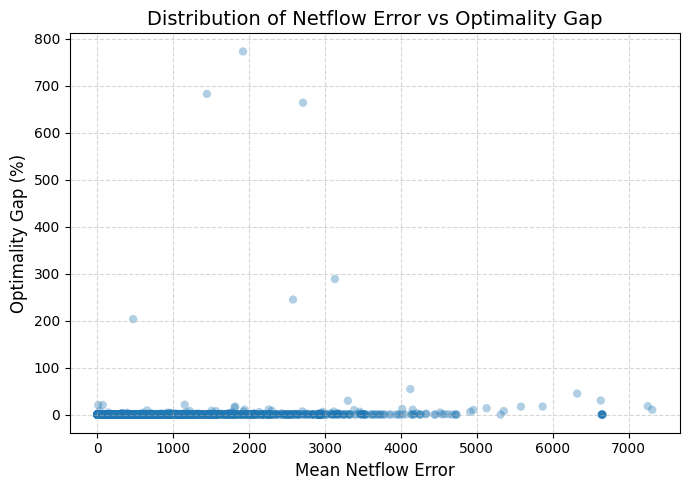

In [195]:
plt.figure(figsize=(7,5))
plt.scatter(net_err, opt_gap_all, alpha=0.35, edgecolors='none')

plt.xlabel("Mean Netflow Error", fontsize=12)
plt.ylabel("Optimality Gap (%)", fontsize=12)
plt.title("Distribution of Netflow Error vs Optimality Gap", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

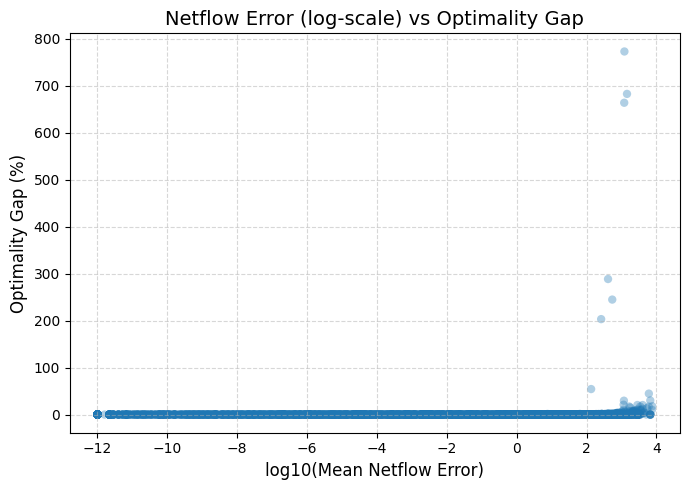

In [198]:
plt.figure(figsize=(7,5))
plt.scatter(np.log10(net_err + 1e-12), opt_gap_all, alpha=0.35, edgecolors='none')

plt.xlabel("log10(Mean Netflow Error)", fontsize=12)
plt.ylabel("Optimality Gap (%)", fontsize=12)
plt.title("Netflow Error (log-scale) vs Optimality Gap", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [199]:
print(prod_err)
print(net_err)

[2.19082230e-04 3.08703723e-08 3.75491713e-05 ... 1.07866072e-09
 4.07602177e-08 5.99682281e+00]
[4.38164461e-04 6.17413510e-08 7.50983418e-05 ... 2.15792776e-09
 8.15216481e-08 1.19936456e+01]


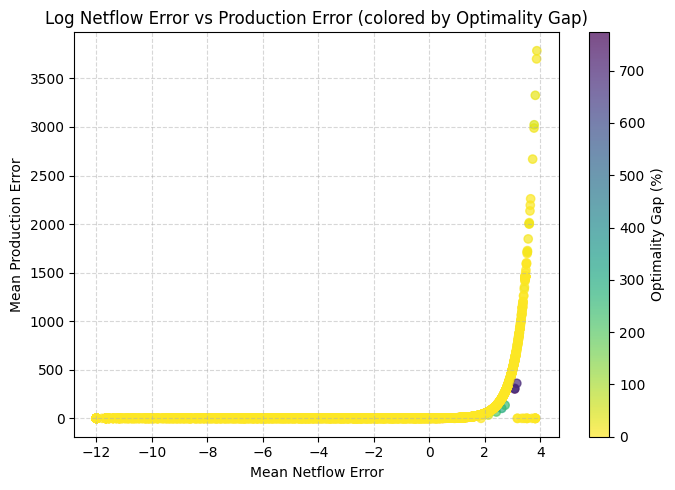

In [205]:
plt.figure(figsize=(7,5))
plt.scatter(np.log10(net_err + 1e-12), prod_err, c=opt_gap_all, cmap='viridis_r', alpha=0.7)
plt.colorbar(label="Optimality Gap (%)")
# log the x

plt.xlabel("Mean Netflow Error")
plt.ylabel("Mean Production Error")
plt.title("Log Netflow Error vs Production Error (colored by Optimality Gap)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Corr(Total unmet demand, opt gap) = -0.0090


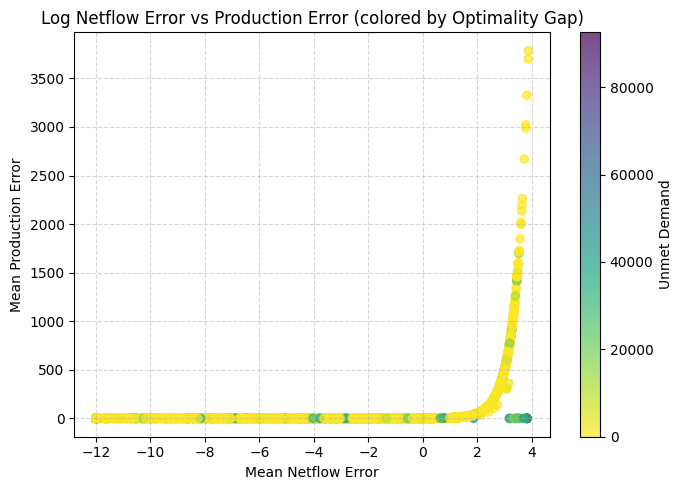

In [ ]:
corr_unmet_opt = np.corrcoef(unmet_dem_pred, opt_gap_all)[0, 1]
print(f"Corr(Total unmet demand, opt gap) = {corr_unmet_opt:.4f}")
plt.figure(figsize=(7,5))
plt.scatter(np.log10(net_err + 1e-12), prod_err, c=unmet_dem_pred, cmap='viridis_r', alpha=0.7)
plt.colorbar(label="Unmet Demand")
# log the x

plt.xlabel("Mean Netflow Error")
plt.ylabel("Mean Production Error")
plt.title("Log Netflow Error vs Production Error (colored by Unmet Demand)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


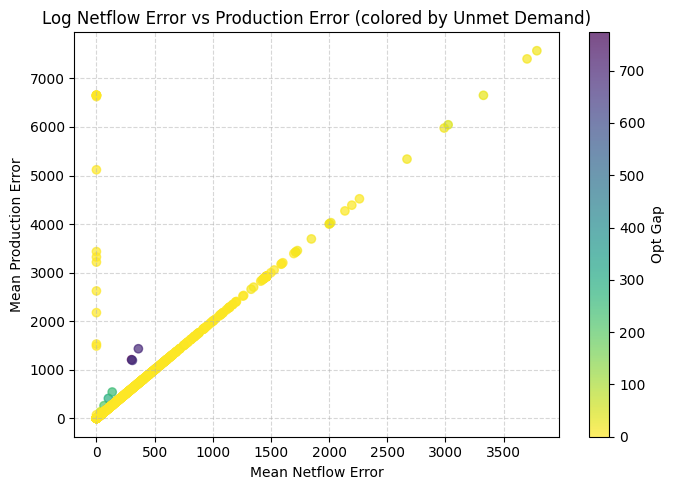

In [216]:

plt.figure(figsize=(7,5))
plt.scatter(prod_err + 1e-12, net_err,c=opt_gap_all, cmap='viridis_r', alpha=0.7)
plt.colorbar(label="Opt Gap")
# log the x

plt.xlabel("Mean Netflow Error")
plt.ylabel("Mean Production Error")
plt.title("Log Netflow Error vs Production Error (colored by Unmet Demand)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [136]:
import torch
import numpy as np

# ---- Compute flow error for each test instance ----
X_test = data.X[test_indices]
Y_pred_all = primal_net(X_test)
p_pred_all, f_pred_all, md_pred_all = data.split_dec_vars_from_Y(Y_pred_all)

Y_gt_all = data.opt_targets["y_operational"][test_indices]
p_gt_all, f_gt_all, md_gt_all = data.split_dec_vars_from_Y(Y_gt_all)

# abs diff per instance per line
flow_diff = torch.abs(f_pred_all - f_gt_all)

# sum or mean over lines
flow_err_per_instance = flow_diff.mean(dim=1)   # (num_instances,)

# ---- Find the worst 10 instances ----
topk = 10
vals, idxs = torch.topk(flow_err_per_instance, k=topk)

print("\n=== Worst flow-prediction instances ===")
for rank, (err, idx) in enumerate(zip(vals, idxs)):
    global_idx = test_indices[idx].item()
    print(f"{rank+1}. Instance {global_idx}  |  Mean flow error = {err.item():.4f}")



=== Worst flow-prediction instances ===
1. Instance 30449  |  Mean flow error = 3992.7894
2. Instance 29642  |  Mean flow error = 3785.2139
3. Instance 30305  |  Mean flow error = 3326.6667
4. Instance 30071  |  Mean flow error = 3326.6643
5. Instance 32536  |  Mean flow error = 3326.6452
6. Instance 31975  |  Mean flow error = 3326.5953
7. Instance 30323  |  Mean flow error = 3326.4460
8. Instance 30004  |  Mean flow error = 3325.9832
9. Instance 31234  |  Mean flow error = 3312.8483
10. Instance 30494  |  Mean flow error = 3029.1287


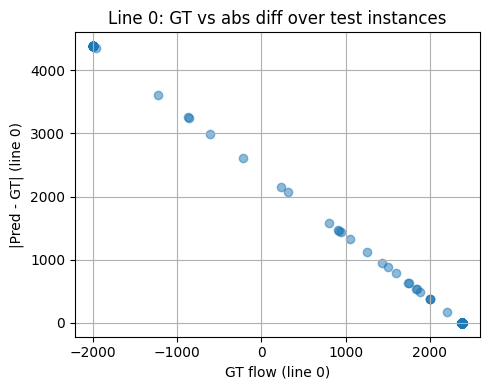

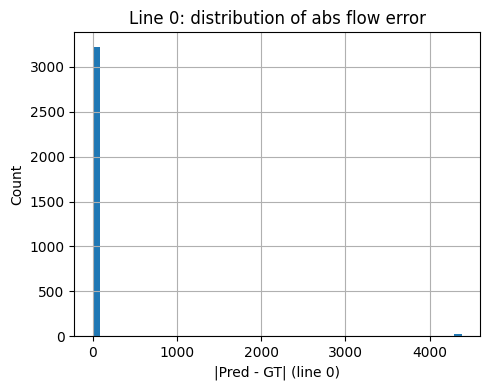

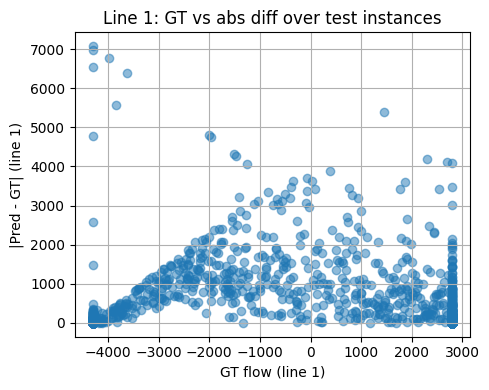

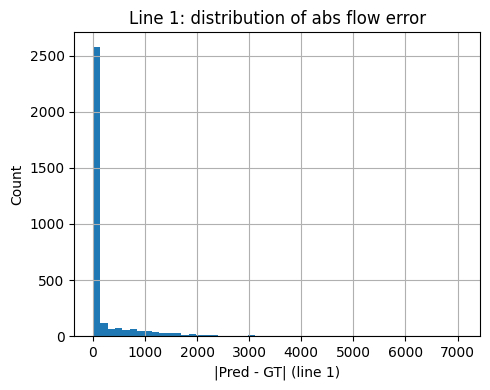

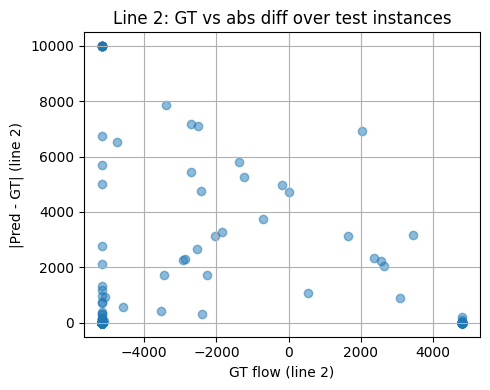

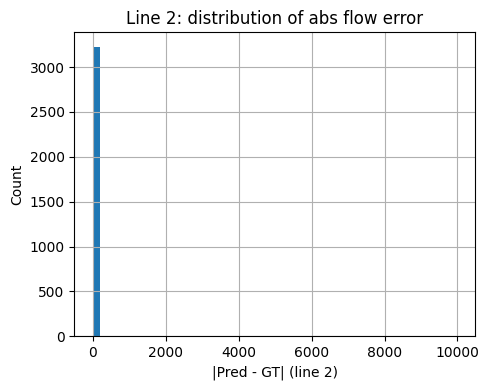

In [127]:
import matplotlib.pyplot as plt
# f_pred_all, f_gt_all should be shape: (num_test_instances, num_lines)
# If they are on GPU, move to CPU first:
f_pred_all_np = f_pred_all.detach().cpu().numpy()
f_gt_all_np   = f_gt_all.detach().cpu().numpy()

# Absolute difference
flow_diff_np = np.abs(f_pred_all_np - f_gt_all_np)   # (N, num_lines)

line_indices = [0, 1, 2]

for l in line_indices:
    gt_vals   = f_gt_all_np[:, l]
    diff_vals = flow_diff_np[:, l]

    # --- Scatter: GT vs |Diff|
    plt.figure(figsize=(5,4))
    plt.scatter(gt_vals, diff_vals, alpha=0.5)
    plt.xlabel(f"GT flow (line {l})")
    plt.ylabel(f"|Pred - GT| (line {l})")
    plt.title(f"Line {l}: GT vs abs diff over test instances")
    plt.grid(True)
    plt.tight_layout()

    # --- Histogram of |Diff|
    plt.figure(figsize=(5,4))
    plt.hist(diff_vals, bins=50)
    plt.xlabel(f"|Pred - GT| (line {l})")
    plt.ylabel("Count")
    plt.title(f"Line {l}: distribution of abs flow error")
    plt.grid(True)
    plt.tight_layout()

plt.show()

In [128]:
import pandas as pd
import numpy as np

tables = {}   # store a table per line

line_indices = [0, 1, 2]

for l in line_indices:
    diff_vals = flow_diff_np[:, l]

    stats = {
        "Mean": np.mean(diff_vals),
        "Median": np.median(diff_vals),
        "Std": np.std(diff_vals),
        "Min": np.min(diff_vals),
        "Max": np.max(diff_vals),
        "P90": np.percentile(diff_vals, 90),
        "P95": np.percentile(diff_vals, 95),
        "P99": np.percentile(diff_vals, 99),
        "# > 10": np.sum(diff_vals > 10),
        "# > 100": np.sum(diff_vals > 100),
        "# > 500": np.sum(diff_vals > 500),
        "# > 1000": np.sum(diff_vals > 1000),
    }

    # convert to DataFrame for nice table printing
    df = pd.DataFrame(stats, index=[f"Line {l}"])
    tables[l] = df

# ---- Print tables ----
for l in line_indices:
    print("\n" + "="*50)
    print(tables[l])



             Mean  Median         Std  Min     Max           P90       P95  \
Line 0  49.431187     0.0  435.971454  0.0  4380.0  1.818989e-11  0.000003   

                P99  # > 10  # > 100  # > 500  # > 1000  
Line 0  2693.187774      54       54       49        42  

              Mean    Median         Std  Min          Max         P90  \
Line 1  238.650011  0.054868  643.164714  0.0  7076.751937  873.869724   

                P95          P99  # > 10  # > 100  # > 500  # > 1000  
Line 1  1469.076779  3195.131634    1103      762      472       284  

             Mean        Median         Std  Min     Max           P90  \
Line 2  65.357184  9.094947e-13  656.916928  0.0  9980.0  3.778463e-07   

             P95          P99  # > 10  # > 100  # > 500  # > 1000  
Line 2  0.003538  2157.383573      68       57       46        40  


In [63]:
import pandas as pd
import numpy as np

line_indices = [0, 1, 2]
rows = []

for l in line_indices:
    diff_vals = flow_diff_np[:, l]

    row = {
        "Line": l,
        "Mean": np.mean(diff_vals),
        "Median": np.median(diff_vals),
        "Std": np.std(diff_vals),
        "Min": np.min(diff_vals),
        "Max": np.max(diff_vals),
        "P90": np.percentile(diff_vals, 90),
        "P95": np.percentile(diff_vals, 95),
        "P99": np.percentile(diff_vals, 99),
        "# > 10": np.sum(diff_vals > 10),
        "# > 100": np.sum(diff_vals > 100),
        "# > 500": np.sum(diff_vals > 500),
        "# > 1000": np.sum(diff_vals > 1000),
    }

    rows.append(row)

# Create single DataFrame
table = pd.DataFrame(rows)

# Optional: nicer column order
table = table[[
    "Line", "Mean", "Median", "Std", "Min", "Max",
    "P90", "P95", "P99", "# > 10",
    "# > 100", "# > 500", "# > 1000"
]]

print("\n=== Combined Flow Error Table ===")
# print(table.to_string(index=False))


print("Totalinstances:", flow_diff_np.shape[0])
table



=== Combined Flow Error Table ===
Totalinstances: 3278


,Line,Mean,Median,Std,Min,Max,P90,P95,P99,# > 10,# > 100,# > 500,# > 1000
0,0,49.471549,0.00000,435.770537,0.0,4380.000000,0.00000,5.866241e-11,2693.187774,56,55,49,42
1,1,233.409961,0.00795,646.172070,0.0,6781.572246,885.01142,1.460630e+03,3169.492907,1016,695,454,288
2,2,64.211843,0.00000,656.733487,0.0,9979.999990,0.00000,6.513642e-06,1893.033582,63,53,47,39


In [77]:
import numpy as np

# diff per instance per line
flow_diff = np.abs(f_pred_all_np - f_gt_all_np)

# exact zero error for each line
zero_line0 = np.sum(flow_diff[:, 0] == 0)
zero_line1 = np.sum(flow_diff[:, 1] == 0)
zero_line2 = np.sum(flow_diff[:, 2] == 0)

# how many instances have all flow errors exactly zero?
zero_all = np.sum(np.all(flow_diff == 0, axis=1))

# how many instances have any line with big errors?
big100 = np.sum(np.any(flow_diff > 100, axis=1))
big500 = np.sum(np.any(flow_diff > 500, axis=1))
big1000 = np.sum(np.any(flow_diff > 1000, axis=1))

print("=== Zero-diff counts ===")
print(f"Line 0: {zero_line0}")
print(f"Line 1: {zero_line1}")
print(f"Line 2: {zero_line2}")
print(f"All 3 lines zero: {zero_all}")

print("\n=== Large-error counts ===")
print(f"Any line > 100:  {big100}")
print(f"Any line > 500:  {big500}")
print(f"Any line > 1000: {big1000}")


=== Zero-diff counts ===
Line 0: 2906
Line 1: 374
Line 2: 1601
All 3 lines zero: 118

=== Large-error counts ===
Any line > 100:  863
Any line > 500:  562
Any line > 1000: 362


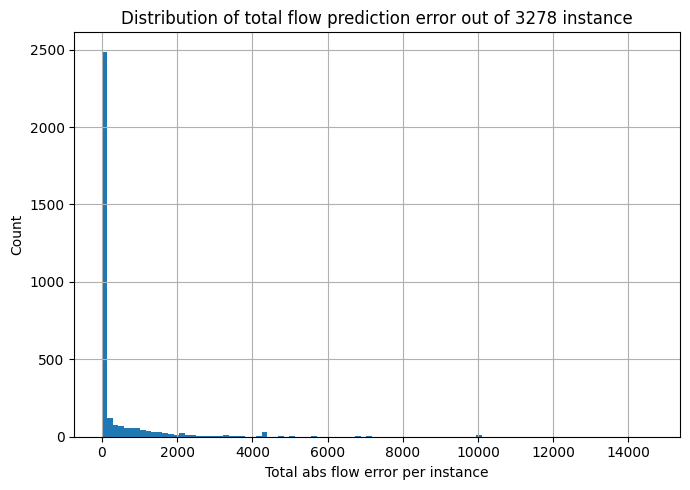

In [83]:
flow_diff = np.abs(f_pred_all_np - f_gt_all_np)   # shape (N, num_lines)
total_instances = flow_diff.shape[0]
flow_err_total = flow_diff.sum(axis=1)    # shape (N,)
plt.figure(figsize=(7,5))
plt.hist(flow_err_total, bins=100)
plt.xlabel("Total abs flow error per instance")
plt.ylabel("Count")
plt.title(f"Distribution of total flow prediction error out of {total_instances} instance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:

print(f"Mean {np.mean(flow_err_total)}")
print(f"Median {np.median(flow_err_total)}")
print(f"Std {np.std(flow_err_total)}")
print(f"Min {np.min(flow_err_total)}")
print(f"Max {np.max(flow_err_total)}")
print(f"P70 {np.percentile(flow_err_total, 70)}")
print(f"P80 {np.percentile(flow_err_total, 80)}")
print(f"P90 {np.percentile(flow_err_total, 90)}")
print(f"P95 {np.percentile(flow_err_total, 95)}")
print(f"P99 {np.percentile(flow_err_total, 99)}")


Mean 353.4383811908196
Median 0.16041589395263145
Std 1023.6660214559342
Min 0.0
Max 14642.247658456441
P70 44.72420517063875
P80 314.06158649573007
P90 1105.310341958035
P95 1926.5826283184322
P99 4387.753415354966


### Relatoinship between flow prediction quality and objective value

In [99]:
import pandas as pd
import numpy as np
import torch

topk =test_indices
worst_local_idxs = idxs[:topk]              # top-k in the test set
worst_local_idxs = worst_local_idxs.cpu().numpy()

rows = []
opt_gaps = []

for rank, local_idx in enumerate(worst_local_idxs, start=1):
    local_idx = int(local_idx)

    # Global index in full dataset
    global_idx = int(test_indices[local_idx].item())

    # Extract single X, Y_pred, Y_gt
    X_i       = X_test[local_idx:local_idx+1]
    Y_pred_i = Y_pred_all[local_idx:local_idx+1]
    Y_gt_i   = Y_gt_all[local_idx:local_idx+1]

    # Objective values (using your obj_fn)
    obj_pred = data.obj_fn(X_i, Y_pred_i).item()
    obj_gt   = data.obj_fn(X_i, Y_gt_i).item()

    # Optimality gap %
    opt_gap = (obj_pred - obj_gt) / (abs(obj_gt) + 1e-9) * 100.0
    opt_gaps.append(opt_gap)

    # Mean flow error for this instance
    mean_flow_err = flow_err_per_instance[local_idx].item()

    rows.append({
        "Rank": rank,
        "GlobalIdx": global_idx,
        "MeanFlowErr": mean_flow_err,
        "GT_Obj": obj_gt,
        "Pred_Obj": obj_pred,
        "OptGap_%": opt_gap,
    })

# Build table
worst_obj_table = pd.DataFrame(
    rows,
    columns=["Rank", "GlobalIdx", "MeanFlowErr", "GT_Obj", "Pred_Obj", "OptGap_%"]
)

# Mean optimality gap over top-k instances
mean_opt_gap = np.mean(opt_gaps)

print("\n=== Objective quality for worst flow-error instances ===")
print(worst_obj_table.to_string(index=False))

print(f"\n=== Mean Optimality Gap over worst {topk} flow-error instances ===")
print(f"{mean_opt_gap:.6f} %")


TypeError: only integer tensors of a single element can be converted to an index

In [105]:
import numpy as np
import pandas as pd
import torch
print(type(flow_diff))
# Make sure we're on CPU numpy for the simple stats
flow_diff_np = flow_diff
p_pred_np    = p_pred_all.detach().cpu().numpy()
p_gt_np      = p_gt_all.detach().cpu().numpy()

# Mean flow error and production error per instance
flow_err_mean = flow_diff_np.mean(axis=1)                     # shape (N_test,)
prod_err_mean = np.abs(p_pred_np - p_gt_np).mean(axis=1)      # shape (N_test,)

# Optimality gap per instance (using your obj_fn)
obj_pred_all = data.obj_fn(X_test, Y_pred_all).detach().cpu().numpy()
obj_gt_all   = data.obj_fn(X_test, Y_gt_all).detach().cpu().numpy()

opt_gap_all = (obj_pred_all - obj_gt_all) / (np.abs(obj_gt_all) + 1e-9) * 100


<class 'numpy.ndarray'>


In [ ]:
rows = []

# iterate over local indices 0..N_test-1
for i in range(len(test_indices)):
    global_idx = int(test_indices[i].item())

    rows.append({
        "GlobalIdx": global_idx,
        "FlowErrMean": flow_err_mean[i],
        "ProdErrMean": prod_err_mean[i],
        "GT_Obj": obj_gt_all[i],
        "Pred_Obj": obj_pred_all[i],
        "OptGap_%": opt_gap_all[i],
    })

rel_table = pd.DataFrame(
    rows,
    columns=["GlobalIdx", "FlowErrMean", "ProdErrMean", "GT_Obj", "Pred_Obj", "OptGap_%"]
)

print("\n=== Per-instance error vs optimality table (first 10 rows) ===")
print(rel_table.head(10).to_string(index=False))

# If you like, save it for later analysis
rel_table.to_csv("error_vs_optgap_all_test.csv", index=False)
rel


=== Per-instance error vs optimality table (first 10 rows) ===
 GlobalIdx  FlowErrMean  ProdErrMean        GT_Obj      Pred_Obj     OptGap_%
     29490 1.433077e-02 1.433077e-02 278147.776732 278147.776947 7.728323e-08
     29491 1.324831e-10 7.700388e-11   1746.442221   1746.442221 2.525734e-12
     29492 3.441295e-04 3.441295e-04    936.505544    936.505550 5.511948e-07
     29493 2.353451e+00 2.353451e+00   2771.797418   2771.832720 1.273605e-03
     29494 5.174162e+02 5.174162e+02   1413.293164   1421.054408 5.491602e-01
     29495 8.584623e+02 8.584623e+02   1375.499529   1388.376464 9.361642e-01
     29496 2.566972e-02 2.566972e-02   1918.566815   1918.567200 2.006945e-05
     29497 3.987374e+01 3.987374e+01 338901.651711 338902.249817 1.764837e-04
     29498 8.393274e-05 8.393274e-05 338936.172914 338936.172915 3.714485e-10
     29499 0.000000e+00 3.031649e-13   1061.586564   1061.586564 1.285097e-12


In [107]:
# Correlations
flow_corr = np.corrcoef(rel_table["FlowErrMean"], rel_table["OptGap_%"])[0,1]
prod_corr = np.corrcoef(rel_table["ProdErrMean"], rel_table["OptGap_%"])[0,1]
print(f"\nCorrelation(flow_err_mean, opt_gap): {flow_corr:.4f}")
print(f"Correlation(prod_err_mean, opt_gap):  {prod_corr:.4f}")



Correlation(flow_err_mean, opt_gap): 0.0690
Correlation(prod_err_mean, opt_gap):  0.0565


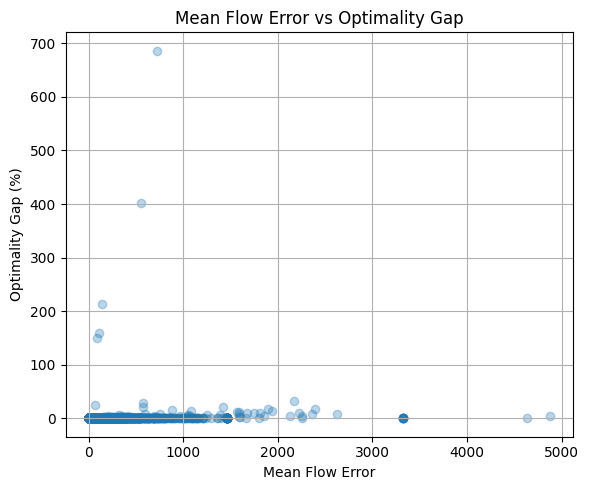

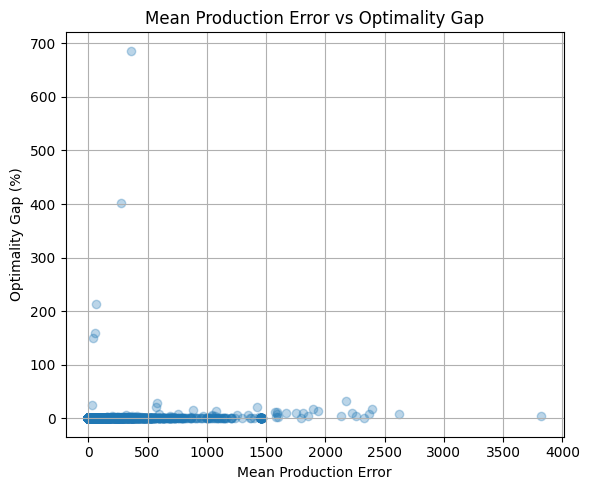

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(rel_table["FlowErrMean"], rel_table["OptGap_%"], alpha=0.3)
plt.xlabel("Mean Flow Error")
plt.ylabel("Optimality Gap (%)")
plt.title("Mean Flow Error vs Optimality Gap")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(rel_table["ProdErrMean"], rel_table["OptGap_%"], alpha=0.3)
plt.xlabel("Mean Production Error")
plt.ylabel("Optimality Gap (%)")
plt.title("Mean Production Error vs Optimality Gap")
plt.grid(True)
plt.tight_layout()
plt.show()
